In [75]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed,  Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tqdm.keras import TqdmCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [4]:
COUNTRIES = ["Yemen", "Syria"]

In [5]:
PATH_TO_DATA_FOLDER = lambda x: "../../Dataset time-series/data/" + x + "/"

In [6]:
trains = list()
trains_smooth = list()
tests = list()
targets = list()
for country in COUNTRIES:
    # Load the dataset of the training sets.
    train = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "train.csv", header = [0, 1], index_col = 0)
    train.index.name = "Datetime"
    train.index = pd.to_datetime(train.index)
    freq = "D"
    train.index.freq = freq
    train.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), train.columns))
    trains.append(train)
    # Load the dataset of the smoothed training sets.
    train_smooth = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "train_smooth.csv", header = [0, 1], index_col = 0)
    train_smooth.index.name = "Datetime"
    train_smooth.index = pd.to_datetime(train_smooth.index)
    freq = "D"
    train_smooth.index.freq = freq
    train_smooth.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), train_smooth.columns))
    trains_smooth.append(train_smooth)
    # Load the dataset of the test sets.
    test = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "test_target.csv", header = [0, 1], index_col = 0)
    test.index.name = "Datetime"
    test.index = pd.to_datetime(test.index)
    freq = "D"
    test.index.freq = freq
    test.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), test.columns))
    tests.append(test)
    # Load the dataset of the whole time-series of the fcs indicator.
    target = pd.read_csv(PATH_TO_DATA_FOLDER(country) + "all_target.csv", header = [0, 1], index_col = 0)
    target.index.name = "Datetime"
    target.index = pd.to_datetime(target.index)
    freq = "D"
    target.index.freq = freq
    target.columns = pd.MultiIndex.from_tuples(map(lambda x: (country, x[0], x[1]), target.columns))
    targets.append(target)

In [7]:
train = pd.concat(trains, axis = 1)
train.columns.rename("Country", level = 0, inplace = True)
train.columns.rename("AdminStrata", level = 1, inplace = True)
train.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
train.index.freq = freq
train.dropna(axis = 0, how = "all", inplace = True)

In [8]:
train_smooth = pd.concat(trains_smooth, axis = 1)
train_smooth.columns.rename("Country", level = 0, inplace = True)
train_smooth.columns.rename("AdminStrata", level = 1, inplace = True)
train_smooth.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
train_smooth.index.freq = freq
train_smooth.dropna(axis = 0, how = "all", inplace = True)

In [9]:
test = pd.concat(tests, axis = 1)
test.columns.rename("Country", level = 0, inplace = True)
test.columns.rename("AdminStrata", level = 1, inplace = True)
test.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
test.index.freq = freq

In [10]:
target = pd.concat(targets, axis = 1)
target.columns.rename("Country", level = 0, inplace = True)
target.columns.rename("AdminStrata", level = 1, inplace = True)
target.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
target.index.freq = freq

In [11]:
TEST_SIZE = 30
FREQ = train.index.freq

In [12]:
TRAIN = train.copy()
TRAIN_SMOOTH = train_smooth.copy()

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [13]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [14]:
# In this way the SCALER variable to inverse the transformation is only based on data smoothed (they are independent).
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = [0, 2]).apply(lambda x: normalization(x, (MIN, MAX)))
TRAIN_SMOOTH_NORMALIZED = TRAIN_SMOOTH.groupby(axis = 1, level = [0, 2]).apply(lambda x: normalization(x, (MIN, MAX)))

In [15]:
# Plot time-series.
#TsIP(TRAIN_SMOOTH_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines", 
#                                                  first_last_valid_index_group = True)

In [16]:
def denormalization(group_scaled, country, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[(country, indicator)]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

## Training

In [165]:
N_SEQ = 2
N_STEPS = 7
LAGS = N_SEQ*N_STEPS

In [166]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = LAGS
lags_dict["1 Month Anomaly (%) Rainfall"] = None
lags_dict["Cereals and tubers"] = LAGS
lags_dict["Exchange rate (USD/LCU)"] = LAGS
lags_dict["FCS"] = LAGS
lags_dict["Fatality"] = LAGS
lags_dict["NDVI Anomaly"] = LAGS
lags_dict["Rainfall (mm)"] = LAGS
lags_dict["rCSI"] = LAGS
lags_dict["Lat"] = None
lags_dict["Lon"] = None
lags_dict["Population"] = LAGS
lags_dict["Ramadan"] = LAGS

In [167]:
X_train_list, y_train_list = list(), list()
X_test_dict = dict() 
for COUNTRY in COUNTRIES:
    subdf = TRAIN_NORMALIZED[COUNTRY]
    TRAIN_NORMALIZED_SETS = find_multiple_sets(subdf.loc[subdf.first_valid_index():subdf.last_valid_index()])      
    PROVINCES = subdf.columns.get_level_values(0).unique()  

    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        # Create training points from the training set.
        for PROVINCE in PROVINCES:
            # Initialize lags creator.
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, n_out = TEST_SIZE, target = "FCS", 
                                  return_dataframe = False)
            # Get samples.
            X_train, y_train, _, _, X_test = creator.to_supervised(single_step = False, feature_time = False, validation = False, 
                                                                   dtype = np.float64)
            
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)

            if "Smooth" in COUNTRY:
                # Add the test sample of the province of the current set into a dictionary.
                X_test_dict[(PROVINCE, i)] = X_test

# Merge all the provinces. (n_samples, time-steps, n_features)
X_train = np.concatenate(X_train_list)
# Merge all the provinces. (n_samples, n_out)
y_train = np.concatenate(y_train_list)

print("Training shape: X:", X_train.shape, "y:", y_train.shape)

Training shape: X: (24980, 14, 10) y: (24980, 30)


In [168]:
N_FEATURES = X_train.shape[2]

In [169]:
def network(timesteps, features, n_out):      
    model = Sequential() 

    # MODEL.
    model.add(TimeDistributed(Conv1D(3, 3, activation = "relu", input_shape = (None, N_STEPS, N_FEATURES))))
    #model.add(TimeDistributed(Conv1D(64, 3, activation = "relu", )))
    model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(10, activation = "relu", return_sequences = False))
    model.add(Dropout(0.3))

    model.add(Dense(n_out))  

    return model

In [170]:
N_EPOCHS = 100
BATCH_SIZE = 128

In [171]:
X_train = X_train.reshape((X_train.shape[0], N_SEQ, N_STEPS, N_FEATURES))

Training the network:


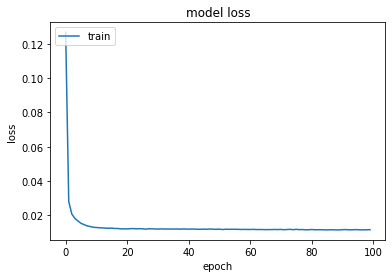

In [172]:
print("Training the network:")

model = network(LAGS, N_FEATURES, TEST_SIZE)
# Compile model.
model.compile(loss = "mse", optimizer = "adam")
# Fit model.
history = model.fit(X_train, y_train, epochs = N_EPOCHS, batch_size = BATCH_SIZE, verbose = 0, shuffle = True, 
                    callbacks = [TqdmCallback(verbose = 1)])

# Plot result of the training and validation.
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc = "upper left")
plt.show()

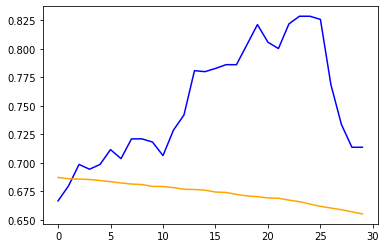

In [173]:
# Example.

id_ = 8

X_test = np.expand_dims(X_train[id_], axis = 0)

pred = model.predict(X_test).flatten()
actual = y_train[id_]

# Plot the predictions.
plt.plot(actual, "blue")
plt.plot(pred, "orange");

# Forecasting a country

In [174]:
COUNTRY_TO_FORECAST = "Yemen"

In [175]:
TEST_TARGET_SETS = find_multiple_sets(test[COUNTRY_TO_FORECAST])

In [176]:
FORECASTING_NORMALIZED = test[COUNTRY_TO_FORECAST].copy()
# Prediction over the test sets.
for i, test_set in enumerate(TEST_TARGET_SETS):
    # Prediction for each province.
    for PROVINCE in train[COUNTRY_TO_FORECAST].columns.get_level_values(0).unique():
        X_test = X_test_dict[(PROVINCE, i)]
        X_test = X_test.reshape((X_test.shape[0], N_SEQ, N_STEPS, N_FEATURES))
        # Prediction.
        y_hats = model.predict(X_test, verbose = 0).flatten() 
        # Add the prediction to the dataframe.
        FORECASTING_NORMALIZED[(PROVINCE, "FCS")].loc[test_set.index] = y_hats

In [177]:
# Denormalization.
FORECASTING = denormalization(FORECASTING_NORMALIZED, COUNTRY_TO_FORECAST, "FCS", (MIN, MAX), SCALERS)

In [178]:
# Plot time-series.
TsIP(FORECASTING, target[COUNTRY_TO_FORECAST]).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [179]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [180]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    PROVINCES = test_set.columns.get_level_values(0).unique()
    # Reduce columns to have only the columns of the provinces.
    test_set.columns = test_set.columns.get_level_values(0)
    forecasting_set.columns = forecasting_set.columns.get_level_values(0)
    # Compute losses.
    for PROVINCE in PROVINCES:
        loss = mean_squared_error(test_set[PROVINCE], forecasting_set[PROVINCE])
        losses.append(loss)
        loss_h = mean_squared_error([test_set[PROVINCE]], [forecasting_set[PROVINCE]], multioutput = "raw_values")
        losses_h.append(loss_h)

In [181]:
overall_mse = np.mean(losses)
overall_mse

24.973317129083004

In [162]:
# Load naive model forecasting results.
naive = np.load("../Naive_" + COUNTRY_TO_FORECAST + ".npy")

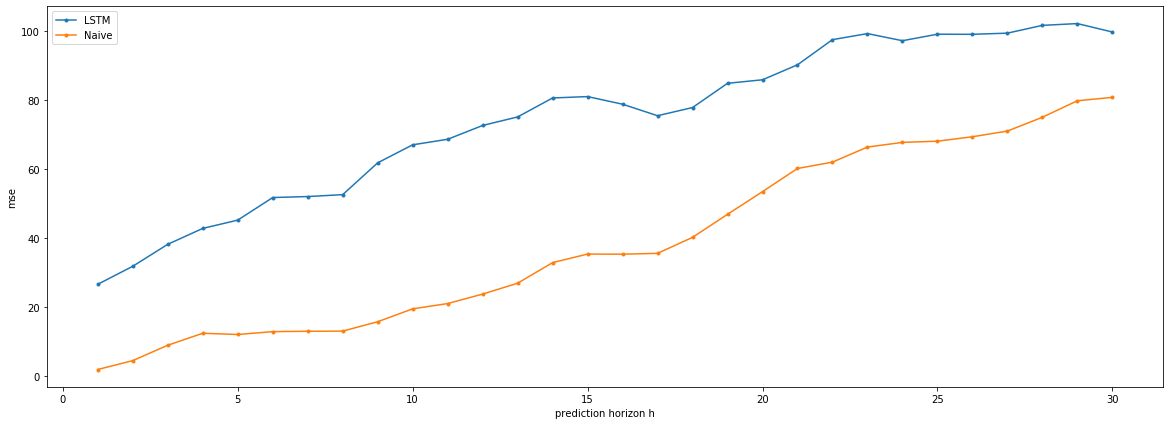

In [163]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-", label = "LSTM")
ax.plot(naive[0], naive[1], ".-", label = "Naive")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10)
ax.legend();